In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat


In [66]:
#importing data
Staller5ADlib = pd.read_csv("data/Staller2022_5AD_library.csv")
Staller_p53AD = pd.read_csv("data/Staller2022_p53AD.csv")
Staller_predictedAD = pd.read_csv("data/Staller2022_predicted_AD.csv")
ChoiADs = pd.read_csv("data/tf_effectordomains.csv")

aa_length_cutoff = 20

ChoiADs = ChoiADs[ChoiADs["Domain type"] == "AD"]
ChoiADs = ChoiADs.set_index("Effector domain ID")[["Sequence", "Activity (H, M or L)"]]
ChoiADs = ChoiADs[[len(x) > aa_length_cutoff for x in ChoiADs["Sequence"]]]

Staller5ADlib_select = Staller5ADlib[["ADseq", "Activity_Mean_MSS18", "Activity_std_MSS18"]].rename({"ADseq": "Sequence"}, axis=1)
Staller5ADlib_select = Staller5ADlib_select[[len(x) >= aa_length_cutoff for x in Staller5ADlib_select["Sequence"]]]

Stallerp53AD_select = Staller_p53AD[["ADseq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ADseq": "Sequence"}, axis=1)
Stallerp53AD_select = Stallerp53AD_select[[len(x) >= aa_length_cutoff for x in Stallerp53AD_select["Sequence"]]]

Staller_predictedAD_select = Staller_predictedAD[["ProteinRegionSeq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ProteinRegionSeq": "Sequence"}, axis=1)
Staller_predictedAD_select = Staller_predictedAD_select[[len(x) >= aa_length_cutoff for x in Staller_predictedAD_select["Sequence"]]]

choiAD_coA_finches = pd.read_csv("helperdata/ChoiADs_coA.csv", index_col=0)
staller5libAD_coA_finches = pd.read_csv("helperdata/Staller5libADs_coA.csv", index_col=0)
stallerP53AD_coA_finches = pd.read_csv("helperdata/StallerP53ADs_coA.csv", index_col=0)
stallerpredictedAD_coA_finches = pd.read_csv("helperdata/StallerPredictedADs_coA.csv", index_col=0)

def activity_category(finchesresult_df, AD_df, activitylabel):
    with_activity = finchesresult_df.merge(AD_df[[activitylabel]], left_on="Prot1", right_index=True, how="left")
    return with_activity

choiAD_coA_finches_activity = activity_category(choiAD_coA_finches, ChoiADs, "Activity (H, M or L)")
staller5libAD_coA_finches_activity = activity_category(staller5libAD_coA_finches, Staller5ADlib_select, "Activity_Mean_MSS18")
stallerP53AD_coA_finches_activity = activity_category(stallerP53AD_coA_finches, Stallerp53AD_select, "Activity_Zscore_mean")
stallerPredictedADs_coA_finches_activity = activity_category(stallerpredictedAD_coA_finches, Staller_predictedAD_select, "Activity_Zscore_mean")

coAs = pd.read_csv("helperdata/coAs.csv", index_col=0)

In [68]:
#calculate correlation for each domain
def correlation_with_activity(df, activity_label, bydomain):
    if bydomain:
        outputdf = pd.DataFrame(index = coAs.index.to_list())
        AD_domainonly_df = df.groupby("Prot2").agg(list)
        for quantvar in ["Attractive e (mf)", "Repulsive e (mf)", "Total e (mf)", "Attractive e (cf)", "Repulsive e (cf)", "Total e (cf)"]:
            selectonly = AD_domainonly_df[[quantvar, activity_label]].dropna()
            if activity_label != quantvar:
                outputdf[quantvar + " Pearson R"] = selectonly.apply(lambda row: stat.pearsonr(row[activity_label], row[quantvar])[0], axis=1)
                outputdf[quantvar + " Spearman R"] = selectonly.apply(lambda row: stat.spearmanr(row[activity_label], row[quantvar])[0], axis=1)
    else:
        outputdf = df.set_index(["Prot1", "Prot2"]).corr()
    return outputdf

In [82]:
#Check if any domains show correlation between interaction and activity: Answer - No
staller5lib_corrs = correlation_with_activity(staller5libAD_coA_finches_activity, "Activity_Mean_MSS18", True)
stallerP53AD_corrs = correlation_with_activity(stallerP53AD_coA_finches_activity, "Activity_Zscore_mean", True)
stallerPredictedADs_corrs = correlation_with_activity(stallerPredictedADs_coA_finches_activity, "Activity_Zscore_mean", True)

staller5lib_corrs_highest = abs(staller5lib_corrs).max().max()
stallerP53AD_corrs_highest = abs(stallerP53AD_corrs).max().max()
stallerPredictedADs_corrs_highest = abs(stallerPredictedADs_corrs).max().max()

if staller5lib_corrs_highest >= 0.6:
    print("5Lib", abs(staller5lib_corrs).stack().idxmax(), staller5lib_corrs_highest)
if stallerP53AD_corrs_highest >= 0.6:
    print("P53", abs(stallerP53AD_corrs).stack().idxmax(), stallerP53AD_corrs_highest)
if stallerPredictedADs_corrs_highest >= 0.6:
    print("Predicted", abs(stallerPredictedADs_corrs).stack().idxmax(), stallerPredictedADs_corrs_highest)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/1469551522.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


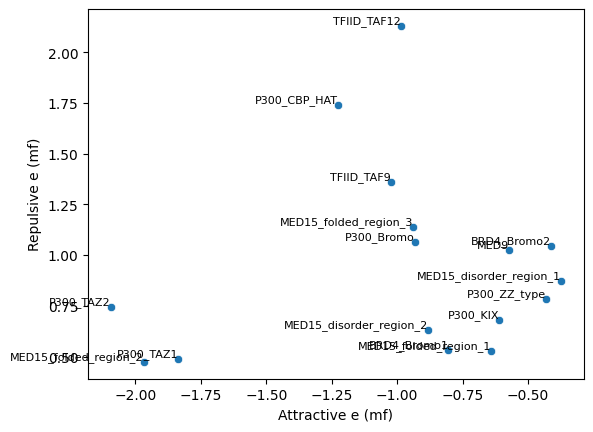

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/1469551522.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


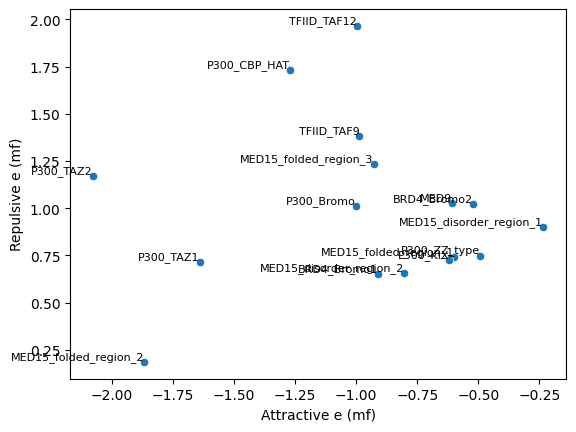

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/1469551522.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


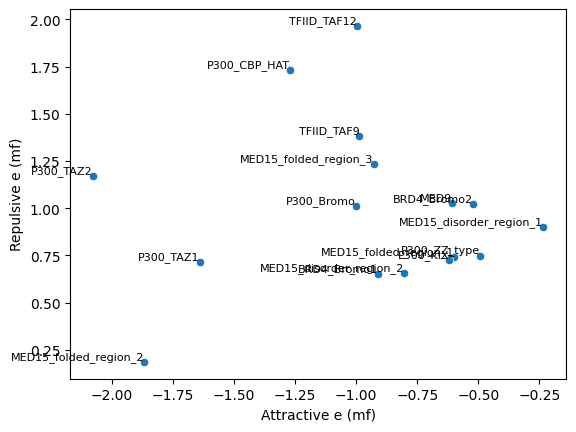

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/1469551522.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


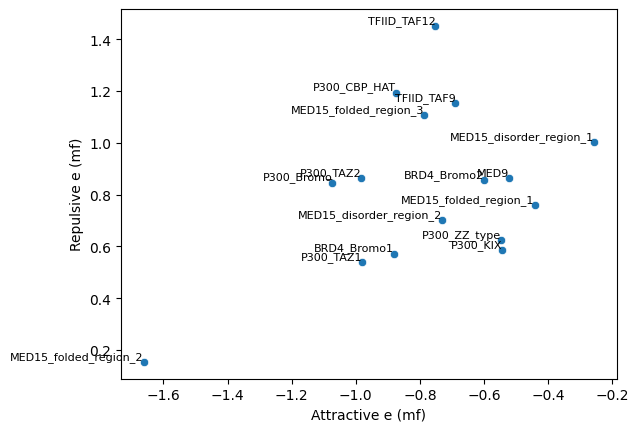

In [110]:
def plot_interaction_by_group(df, aggfunc, activity_label):
    mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)
    mean_interaction_df

    x_label = "Attractive e (mf)"
    y_label = "Repulsive e (mf)"

    sns.scatterplot(mean_interaction_df, x = x_label, y = y_label)

    for i in range(len(mean_interaction_df)):
        plt.text(mean_interaction_df[x_label].iloc[i], mean_interaction_df[y_label].iloc[i], mean_interaction_df.index[i],
                fontsize=8, ha='right', va='bottom')
    plt.show()

plot_interaction_by_group(staller5libAD_coA_finches_activity, np.mean, activity_label = "Activity_Mean_MSS18")
plot_interaction_by_group(stallerP53AD_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(stallerPredictedADs_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(choiAD_coA_finches_activity, np.mean, activity_label = "Activity (H, M or L)")


In [ ]:
#Can we map interaction strength between AD and CoA to sequence features of the CoA?


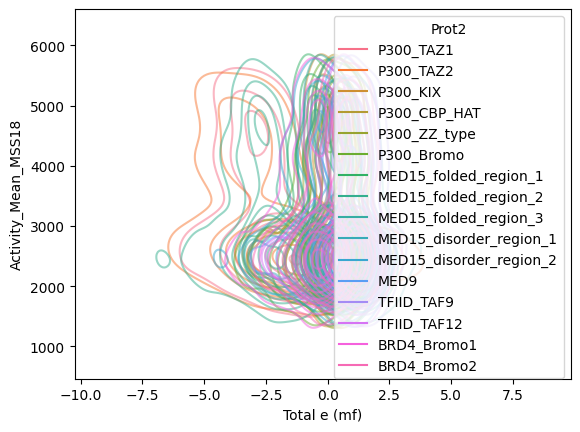

In [95]:
ax = sns.kdeplot(staller5libAD_coA_finches_activity, x = "Total e (mf)", y = "Activity_Mean_MSS18", hue = "Prot2", alpha=0.5)
